In [128]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
# from model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Define environments with different variance structures

We construct a Mouselab-MDP with a symmetric tree structure by specifying a branching structure
and a function `reward(depth) -> Distribution` that specifies the reward distribution for
the nodes at each depth. The ground truth for each environment is determined when the `MouselabEnv`
object is instantiated. We can keep the ground truth constant by specifying a `seed` value. Each
env will have a different ground truth, but if we call `envs = make_envs(n=10, seed=1)` multiple times,
`env[4]` will always have the same ground truth.

In [132]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_envs(cost=1.00, n=100, seed=None,variance_structure="binary_tree_constant_high",branching=[2,2]):
    if seed is not None:
        np.random.seed(seed)
    
    depth = len(branching)
    
    if variance_structure is "binary_tree_constant_high":
        sigmas = np.concatenate( (np.array([0]),6*np.ones(depth)))
    if variance_structure is "binary_tree_increasing":
        sigmas = [0, 2, 20]
    if variance_structure is "binary_tree_decreasing":
        sigmas = [0,20,2]
    if variance_structure is "binary_tree_constant_low":
        sigmas = np.concatenate( (np.array([0]),3*np.ones(depth)))
        
    def reward(depth):
        if depth > 0:
            return Normal(0, sigmas[depth]).to_discrete(6)
        return 0.

    envs = [MouselabEnv.new_symmetric(branching, reward)
            for _ in range(n)]
    for env in envs:
        env.cost=-cost
    
    return envs

# Save environments to JSON files

In [134]:
import json

def env_data(env):
    return {
        'trial_id': hash(env) % 100000000,
        'stateRewards': list(map(round,env.ground_truth)),
    }

cost = 1.00
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]
nr_environments = 1000

for env_type in environments:
    envs = make_envs(cost,nr_environments,None,env_type)

    with open('data/experiment_trials/binary_trees_'+env_type+'.json','w+') as f:
        json.dump(list(map(env_data, envs)), f)

# Compute the LC policy for each of these environments

In [96]:
from mouselab_policy import MouselabPolicy

def lc_policy(x, normalize_voi=True):
    x = np.array(x)
    assert len(x) == 4, x
    voi = x[1:]
    if normalize_voi and voi.sum():
        voi /= voi.sum()
    # Note: an `is_term` feature is functionally equivalent to a `cost` feature
    # when all clicks have the same cost.
    weights = dict(zip(['is_term', 'voi_myopic', 'vpi_action', 'vpi_full'], x))
    return MouselabPolicy(weights)

In [111]:
from contexttimer import Timer

#COSTS = [0.1,0.5, 1, 1.25, 2, 4]
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]
#environments = ["binary_tree_constant_low"]

def avg_utility(x,train_envs):
    with Timer() as t:
        util = get_util(lc_policy(x), train_envs)
        xs =  np.array2string(np.array(x), 
                              formatter={'float_kind': lambda x: f'{x: 6.2f}'})
        print(f'{xs} -> {util:6.3f}  ({t.elapsed:2.1f} seconds)')
    return util

bounds = [
    (-30., 30.), # is_term
    (0., 1.),    # voi_myopic
    (0., 1.),    # vpi_action
    (0., 1.),    # vpi_full
]

from skopt import gp_minimize

#LC_policies = dict()
#weights = dict()
try: 
    LC_policies
except NameError:
    weights = np.load('data/weights_by_environment.npy')
    for env in environments:
        LC_policies[env]=lc_policy(weights[env])

cost = 1.00;
#for c in COSTS:
for env_type in environments:
    envs = make_envs(cost,100,None,env_type)#(cost=1.25, n=100, seed=None,variance_structure="constant_high"):
    def loss(x):
        return - avg_utility(x,envs) 
    
    result = gp_minimize(loss, bounds, n_calls=100, random_state=0)
    LC_policies[env_type] = lc_policy(result.x)


for env in environments:
    weights[env] = LC_policies[env].weights

np.save('data/LC_weights_for_binary_trees.npy',weights)



[  2.93   0.72   0.60   0.54] ->  0.246  (0.2 seconds)
[ -4.58   0.65   0.44   0.89] -> -0.546  (0.7 seconds)
[ 27.82   0.38   0.79   0.53] ->  0.246  (0.2 seconds)
[  4.08   0.93   0.07   0.09] ->  0.246  (0.2 seconds)
[-28.79   0.83   0.78   0.87] -> -1.824  (0.7 seconds)
[ 28.72   0.80   0.46   0.78] ->  0.246  (0.2 seconds)
[-22.90   0.64   0.14   0.94] -> -1.824  (0.7 seconds)
[  1.31   0.41   0.26   0.77] ->  0.650  (0.4 seconds)
[ -2.63   0.57   0.02   0.62] ->  0.006  (0.6 seconds)
[  6.73   0.62   0.94   0.68] ->  0.246  (0.2 seconds)
[  8.47   0.00   0.00   0.00] ->  0.246  (0.0 seconds)
[  2.10   0.00   0.00   1.00] ->  0.566  (0.2 seconds)
[ 18.41   1.00   0.00   1.00] ->  0.246  (0.2 seconds)
[  2.07   0.00   1.00   0.00] ->  0.472  (0.2 seconds)
[  0.53   0.00   0.00   1.00] ->  0.376  (0.3 seconds)
[ 22.59   0.00   1.00   0.00] ->  0.246  (0.1 seconds)
[ 14.74   0.00   1.00   1.00] ->  0.246  (0.2 seconds)
[ 30.00   0.00   0.58   0.15] ->  0.246  (0.2 seconds)
[  3.17   

In [98]:
LC_policies[env].weights

OrderedDict([('is_term', -5.7794558064077215),
             ('term_reward', 1),
             ('voi_myopic', 0.40188963457315541),
             ('vpi_action', 0.19622073085368916),
             ('vpi_full', 0.40188963457315541),
             ('quality_ev', 0),
             ('quality_std', 0),
             ('depth', 0)])

# Inspect LC policies

## Load LC policies

In [32]:
from agents import run_episode

#environments = ["constant_high","constant_low","increasing","decreasing"]
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]

#load policies
try:
    LC_policies
except NameError:
    LC_policies = dict()

weights = np.load('data/LC_weights_for_binary_trees.npy').item()
for env_type in environments:
    x = [weights[env_type]['is_term'],weights[env_type]['voi_myopic'],weights[env_type]['vpi_action'],weights[env_type]['vpi_full']]
    LC_policies[env_type]= lc_policy(x)

## Inspect LC policy for the environment with outward-increasing variance

In [99]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_increasing")

leaf_nodes = [2,3,5,6]
nr_leafs = len(leaf_nodes)

all_leafs= []
not_all_leafs=[]
nr_leafs_inspected = []
nr_nonleafs_inspected = []
nongoal_before_goal = []
first_click_on_goal = np.array([])

for env in envs:
    trace = run_episode(LC_policies["binary_tree_increasing"], env)
    all_leafs.append(np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    not_all_leafs.append(not np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_leafs_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonleafs_inspected.append(len(trace['actions'][:-1])- nr_leafs_inspected[-1])
    is_goal = np.in1d(trace['actions'][:-1],leaf_nodes)
    first_click_on_goal = np.append(first_click_on_goal,[is_goal[0]])
    if all_leafs[-1]:
        nongoal_before_goal.append(False)
    else:
        first_nongoal = np.where(is_goal == False)
        nongoal_before_goal.append(first_nongoal[0][0]<nr_leafs) 

In [100]:
print("Fraction of trials in which the first click inspected a goal: {}".format(np.mean(first_click_on_goal)))
print("Fraction of trials in which only goals were inspected: {}".format(np.mean(all_leafs)))
print("Fraction of trials in which a non-goal was inspected before all goals had been inspected: {}".format(np.mean(nongoal_before_goal)))

all_leafs_array = np.array(all_leafs)
nr_leafs_array = np.array(nr_leafs_inspected)
nr_nonleafs_array = np.array(nr_nonleafs_inspected)
np.mean(nr_leafs_array[~all_leafs_array])

print("Avg. number of leafs inspected when non-leafs were inspected: {}".format(np.mean(nr_leafs_array[~all_leafs_array])))
print("Avg. number of non-leafs inspected when any nonleafs were inspected: {}".format(np.mean(nr_nonleafs_array[~all_leafs_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["binary_tree_increasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

Fraction of trials in which the first click inspected a goal: 1.0
Fraction of trials in which only goals were inspected: 0.939
Fraction of trials in which a non-goal was inspected before all goals had been inspected: 0.001
Avg. number of leafs inspected when non-leafs were inspected: 4.0
Avg. number of non-leafs inspected when any nonleafs were inspected: 2.0
Example sequence: 
[2, 5, 6, 3, 7]
[3, 6, 2, 5, 4, 1, 7]


## Inspect Policy for environment with decreasing variance

In [233]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_decreasing")

leaf_nodes = [3,4,7,8,11,12,15,16]
stem_nodes = [1,5,9,13]
branch_nodes = [2,6,10,14]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

for env in envs:
    trace = run_episode(LC_policies["binary_tree_decreasing"], env)
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
    

Fraction of trials in which only immediate outcomes were inspected: 0.771
Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: 0.0
Avg. number of immediate outcomes inspected when later outcomes were inspected: 4.0
Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: 4.637554585152839
Example sequence: 
[13, 17]


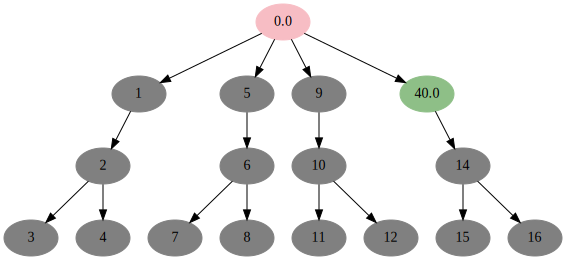

[13, 9, 5, 1, 17]


In [234]:
print("Fraction of trials in which only immediate outcomes were inspected: {}".format(np.mean(all_stems)))
print("Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: {}".format(np.mean(nonstem_before_stem)))


all_stems_array = np.array(all_stems)
nr_stems_array = np.array(nr_stems_inspected)
nr_nonstems_array = np.array(nr_nonstems_inspected)
np.mean(nr_stems_array[~all_stems_array])

print("Avg. number of immediate outcomes inspected when later outcomes were inspected: {}".format(np.mean(nr_stems_array[~all_stems_array])))
print("Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: {}".format(np.mean(nr_nonstems_array[~all_stems_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["binary_tree_decreasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

## Inspect policies for the environment with constant high variance

In [126]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_constant_high")

leaf_nodes = [2,3,5,6]
stem_nodes = [1,4]
#branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_branch_nodes_inspected = []
nr_leaf_nodes_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations = []

nr_observations_by_branch = np.empty([nr_environments,4])

e=0
for env in envs:
    trace = run_episode(LC_policies["binary_tree_constant_high"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    #nr_branch_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],branch_nodes)))
    nr_leaf_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))
    
    
    
    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    e+=1

The average number of observations was 4.78.
0.052
0.9145
nan
0.737
nan
nan
nan
Example sequence: 
[4, 5, 1, 6, 3, 2, 7]
[ 0.   0.5  0.   0.   0.5  0.   0.   0. ]
[ 0.   0.   0.   0.   0.   0.5  0.5  0. ]
[ 0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  1.  0.]
[ 0.   0.   0.5  0.5  0.   0.   0.   0. ]
[ 0.  0.  1.  0.  0.  0.  0.  0.]


/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


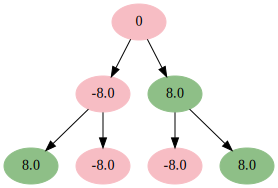

In [127]:
import time
print("The average number of observations was %.2f." % np.mean(nr_observations))

print(np.mean(all_stems))
print(np.mean(nr_stems_inspected)/len(stem_nodes))
print(np.mean(nr_branch_nodes_inspected)/len(branch_nodes))
print(np.mean(nr_leaf_nodes_inspected)/len(leaf_nodes))


print(np.mean(np.amax(nr_observations_by_branch,1)))
print(np.mean(np.amin(nr_observations_by_branch,1)))
print(np.mean(np.amax(nr_observations_by_branch,1)-np.amin(nr_observations_by_branch,1)))

print("Example sequence: ")
env = envs[2]

agent = Agent()
agent.register(LC_policies['binary_tree_constant_high'])
agent.register(env)
trace = run_episode(LC_policies["binary_tree_constant_high"], env)

print(trace['actions'])
env.reset()

env.render()

t=0
for a in trace['actions'][0:-1]:
    env.step(a)
    print(LC_policies['binary_tree_constant_high'].action_distribution(trace['states'][t]))
    env.render()
    #time.sleep(2)
    t+=1
env.render()
#print(trace['actions']) 

#np.save('data/case_study5.npy','env')

In [103]:
final_term_reward = []
nr_observations = []
for env in envs[0:100]:

    agent = Agent()
    agent.register(LC_policies['binary_tree_constant_high'])
    agent.register(env)
    trace = run_episode(LC_policies["binary_tree_constant_high"], env)
    #print(trace['actions'])

    env.reset()
    t=0
    for a in trace['actions'][0:-1]:
        env.step(a)
        #print(LC_policies['constant_high'].action_distribution(trace['states'][t]))
        #env.render()
        t+=1
    final_term_reward.append(env.expected_term_reward(trace['states'][t]))
    nr_observations.append(len(trace['actions'])-1)

In [106]:
term_rewards_array = np.array(final_term_reward)
nr_obs_array = np.array(nr_observations)

np.min(term_rewards_array[nr_obs_array<5])

#vals = np.linspace(-40+8, 40+8, 6)
#delta = vals[1] - vals[0]
#bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
#print(bins)

32.0

## Case Study Protocols

### Case Study 1

1. Step 1: It picks one of the non-leafs at random.
             Outcome: Observed 8 at node 5 on branch 2
2. Step 2: It inspects one of the leafs of branch 2. This is like best-first search or depth-first search but incompatible with breadth-first search.
             Outcome: Observed 8 on node 8 of branch 2

3. Step 3: It randomly picks one of the 6 non-leafs of the other 3 branches. This is different from best-first search which would have inspected another node on branch 2.
             Outcome: observed 8 on node 2 on branch 1

4. Step 4: It deterministically observes the other non-leaf of branch 1. This is also incompatible with best-first search which would explore branch 2.
             Outcome: observed -8 for node 1 on branch 1.

5. Step 5: It observes a non-leaf node on one of the two unexplored branches. This is again different from best-first search or depth-first search, or backward search. Only breadth-first search would do something like that.
             Outcome: observed +8 for node 14 on branch 4.

6. Step 6: It deterministically observes the other non-leaf node of branch 4.
            Outcome: +8 on node 13 on branch 4

7. Step 7: It deterministically observes the other non-leaf node of branch 2, presumably to differentiate between the path 5-6-7 and the two equally promising paths on branch 4.
             Outcome: -8

8. Step 8: It observes one of the leafs of branch 4, which is currently the most promising one.
              Outcome: -8 on node 15

9. Step 9: It observes one of the non-leafs of the still unexplored third branch. Again incompatible with best-first search.
               Outcome: +8 on node 10

10. Step 10: It deterministically inspects the other non-leaf of branch 3.
               Outcome: +8
     
11. Step 11: It chooses at random between the three equally promising leafs 11,12,16
              Outcome: -40 on node 12

12. Step 12: It chooses randomly between the most promising two leafs 11 and 16
		Outcome: +8 on node 11
13. Step 13: It deterministically inspects the last promising leaf (node 16)
		Outcome -40 on node 16          
14. Step 14: It picks one of the remaining 3 leafs at random since they are equally promising.
		Outcome: +40 on node 3
15. Step 15: Act.

### Case Study 2

1. Step 1: It picks one of the 8 non-leafs.
		Outcome: 8 on node 10
2. Step 2: It looks at one of the leafs of the inspected good branch.
		Outcome: -8 on node 11 of branch 3

3. Step 3: non-leaf on a different branch
		Outcome: +8 on node 6 of branch 2

4. Step 4: It deterministically looks at the other non-leaf of branch 2.
		Outcome: -40 on node 5 of branch 2

5. Step 5: Inspect a non-leaf on an uninspected branch.
		Outcome: +8 on node 14 of branch 4

6. Sep 6: It deterministically inspects the other non-leaf of branch 4.
		Outcome: -8 on node 13 of branch 4

7. Step 7: Inspect a non-leaf on the unobserved branch 1.
		Outcome: -8 on node 2

8. Step 8: Now that it has looked at all branches, it tests the leaf of the most promising path (9-10-12)
		Outcome: +40 on node 12

9. Step 9: Act

### Case Study 3

6. Step 6: It chooses one of the nodes that is second-most-promising and and informative about two paths at once rather than a node on the most promising path that would be informative about one path only.
		Outcome: +8 on node 1 of branch 1

7. Step 7: Now it prefers a node on the most promising path over the other node that is informative about 2 paths and on the now third-most promising path.
		Outcome: +8 on node 5 of branch 2

8. Step 8: Now it deterministically inspected the node that is informative about two paths and now lies on the third-best path.
		Outcome: -8 on node 10

9. Step 9: It inspects one of the 3 leafs of the best path or the second-best path with equal probability, presumably because the goal is to disambiguate between them.
		Outcome:  +8 on node 3 of branch 1

10. Step 10:  It deterministically inspects the leaf of the current-best path now.
		Outcome: +8 on node 7 on branch 2

11. Step 11: Now it deterministically looks at the leaf of the second-best path.
		Outcome: -8

12. Step 12: Now it deterministically looks at the remaining node that is informative about 2 paths even though it lies on the least promising branch.
		Outcome: +24 on node 14 of branch 4

observations:
	* it gives an exploration bonus to nodes that are informative about multiple paths
	* it cares about whether the current path is best or at least second best


### Case study 4

1. When the initially inspected non-leaf is bad, then it moves on to a different branch.

2. When it finds a really good outcome (+24) on another branch, then it looks at one of its leaf, testing if that’s a good path.

3. When that turns out to be bad (-8) it looks at the other leaf of that very promising branch.

4. When that turns out to be great (+40) then it acts.

## Conclusion

The four case studies suggested that the LC policy for the environment with constantly high variance always operates in one of two modes:
1. Information gathering where it trades off exploiting nodes on promising paths against exploration by giving a bonus to nodes that are informative about multiple paths.
2. Path testing: Where it inspects the leaf nodes of the most promising path(s).

It chooses between these two modes based on how much more promising the most promising  unknown path is compared to the second most promising unknown path. If the most promising path is much more promising then the strategy goes into test mode. Else it stays in information gathering mode. Most of the time it’s in information gathering mode.


This strategy is clearly distinct from any of the traditional search and planning strategies:

* It is distinct from best-first search in that it also cares about the number of paths that the node is informative about.
* It is distinct from breadth first search in that it will continue to explore the same branch if the node(s) observed on it are promising.
* It is distinct from depth-first search in that hops from branch to branch unless the observed value on a branch was really good.
* It doesn’t prune because it will revisit branches with bad outcomes on them after having explored the other branches.
* It doesn’t do backward search because it prefers nodes that are informative about multiple paths and leaf nodes are informative about only one single path. (edited)
* It does have a satisficing component to it in that it will act when it has found a path that has an amazingly high expected return, but it often does a near-exhaustive search when that is not the case.

Its pseudocode might start with something like this:

* Pick a random node that is informative about as many paths as possible.
* Then
  * If it’s outcome is great then look at one of its leafs. 
     *  If the leaf is great, then ??
     * If the leaf is bad, then look at another leaf on that promising branch. And if that one is great, then take it.
  * If it is good but not great, then inspect a non-leaf on a different branch ...
  * If it’s outcome is bad then explore another branch, again prioritizing nodes that are informative about multiple paths

## Qualitative predictions

1. The first observed node is a stem node or branch node rather than a leaf node.
1. If the first observed node is a non-leaf and its revealed value is 8 or larger, then people should inspect a leaf node on the same branch. But if the value is -8 or smaller then they should inspect a non-leaf node on a different branch.
1. People should not stop collecting information until they either find a path with an expected return of at least 32 or have already inspected all nodes.
1. If two nodes lie on paths with similar expected value, then people should prefer to inspect the node that is informative about multiple paths (stem and branch nodes) over nodes that are informative about only a single path (leaf nodes).
1. Unless the observed non-leaf has a value of 24 or higher people should switch to a new branch after at most 2 observations on the first branch they looked at.


## Inspect policy for the environment with constant low variance

In [112]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_constant_low")

leaf_nodes = [2,3,5,6]
stem_nodes = [1,4]
#branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations_by_branch = np.empty([nr_environments,2])

nr_observations = []
first_observation = []

e=0
for env in envs:
    trace = run_episode(LC_policies["binary_tree_constant_low"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    first_observation.append(trace['states'][1][trace['actions'][0]])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))    
    e+=1
        

In [113]:
np.max(nr_observations_by_branch[:,0:1])

3.0

In [114]:
first_observations_array = np.array(first_observation)
nr_observations_array = np.array(nr_observations)

print("The average number of observations was %.2f." % np.mean(nr_observations))

print("The maximum number of observations was {}".format(np.amax(nr_observations)))
print("The minimum number of observations was {}".format(np.amin(nr_observations)))

print("maximum number of observations on the same branch: {}".format(np.max(nr_observations_by_branch[:,0:1])))

print("Avg. first observation that led to termination: {}".format(np.mean(first_observations_array[nr_observations_array==1])))
print("Avg. first observation that led to continuation: {}:".format(np.mean(first_observations_array[nr_observations_array==2])))


#print("Zero observations: %.2f. percent" % 100*np.mean(np.equal(np.array(nr_observations),np.zeros([1000,1]))))
#print("One observation: %.2f. percent" % 100*np.mean(np.array(nr_observations)==1))
#print("Two observations: %.2f. percent" % 100*np.mean(np.array(nr_observations)==2))


print("Example sequence: ")
env=envs[0]
env.reset()
trace = run_episode(LC_policies["binary_tree_constant_low"], env)
print(trace['actions']) 


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 



The average number of observations was 1.79.
The maximum number of observations was 6
The minimum number of observations was 1
maximum number of observations on the same branch: 3.0
Avg. first observation that led to termination: 2.3527559055118106
Avg. first observation that led to continuation: -2.8876080691642656:
Example sequence: 
[4, 7]


# Measure the performance and number of clicks of the LC policies

In [124]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

term_action = 7

def eval_envs(cost, env_type, envs):
    policies = {
        'BO': LC_policies[env_type],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                df['env_type'] = env_type
                yield df
    return pd.concat(loop())


envs_per_type = 1000
chunks_per_job = 5
total_envs = envs_per_type * len(environments)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)

environments=['binary_tree_increasing','binary_tree_constant_low','binary_tree_constant_high']
#environments=['binary_tree_increasing']

cost = 1.00
jobs = [delayed(eval_envs)(cost, env_type, envs) 
        for env_type in environments
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost, envs_per_type,None, env_type))]
result = Parallel(n_job)(tqdm(jobs))

#Save results
results = pd.concat(result)
np.save('data/results_binary_trees.npy',results)


100%|██████████| 132/132 [00:22<00:00,  5.75it/s]

## Inspect the results

In [125]:
import pandas as pd
import numpy as np

#results=pd.DataFrame(np.load('data/results_binary_trees.npy'),columns=[''])

#results = np.load('data/results_variance_structures.npy')
#df = pd.DataFrame(list(results.item().iteritems()), columns=['agent','util','cost','env_type'])

#LC_policies.to_pickle('data/LC_policies_backward_planning.pkl')

#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','env_type']).util.mean())
print(results.groupby(['agent','env_type']).observations.mean())

#results

#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

agent             env_type                 
BO                binary_tree_constant_high    19.834867
                  binary_tree_constant_low      0.343407
                  binary_tree_increasing       16.726953
full-observation  binary_tree_constant_high    19.664000
                  binary_tree_constant_low     -2.148000
                  binary_tree_increasing       14.504000
none              binary_tree_constant_high    -0.148000
                  binary_tree_constant_low     -0.039600
                  binary_tree_increasing        0.072000
Name: util, dtype: float64
agent             env_type                 
BO                binary_tree_constant_high    4.740333
                  binary_tree_constant_low     1.794833
                  binary_tree_increasing       3.013367
full-observation  binary_tree_constant_high    6.000000
                  binary_tree_constant_low     6.000000
                  binary_tree_increasing       6.000000
none              binary_tree_consta

,observations,util,env,agent,cost,env_type
0,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
1,4,3.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
2,6,-16.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
3,4,36.800000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
4,1,27.000000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
5,6,-11.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
6,1,20.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
7,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
8,4,4.266667,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
9,6,-13.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing


In [55]:
results

,0,1,2,3,4,5
0,3,23.4,<MouselabEnv instance>,BO,1,increasing
1,4,24,<MouselabEnv instance>,BO,1,increasing
2,10,2,<MouselabEnv instance>,BO,1,increasing
3,8,18.4,<MouselabEnv instance>,BO,1,increasing
4,6,22,<MouselabEnv instance>,BO,1,increasing
5,10,2,<MouselabEnv instance>,BO,1,increasing
6,2,24.4,<MouselabEnv instance>,BO,1,increasing
7,3,25,<MouselabEnv instance>,BO,1,increasing
8,10,2,<MouselabEnv instance>,BO,1,increasing
9,5,21.4,<MouselabEnv instance>,BO,1,increasing
